# Text Classification (ag_news_subset)

https://www.tensorflow.org/datasets/catalog/ag_news_subset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import helper_functions

tf.__version__

'2.10.0'

## Getting the datasets

In [2]:
# Saved to "C:\Users\lelop\tensorflow_datasets\ag_news_subset\1.0.0"
(train_data, test_data), ds_info = tfds.load(
    # Target dataset to get from TFDS
    name="ag_news_subset",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [3]:
train_data = tfds.as_dataframe(train_data, ds_info)
test_data = tfds.as_dataframe(test_data, ds_info)

train_data['description'] = train_data['description'].str.decode("utf-8")
test_data['description'] = test_data['description'].str.decode("utf-8")
train_data.head()

,description,label
0,AMD #39;s new dual-core Opteron chip is design...,3
1,Reuters - Major League Baseball\Monday announc...,1
2,President Bush #39;s quot;revenue-neutral quo...,2
3,Britain will run out of leading scientists unl...,3
4,"London, England (Sports Network) - England mid...",1


In [4]:
#different categories
class_names = ds_info.features["label"].names
class_names

['World', 'Sports', 'Business', 'Sci/Tech']

In [5]:
train_data.shape, test_data.shape

((120000, 2), (7600, 2))

In [12]:
sentences_length = train_data["description"].apply(lambda x: len(x.split(" ")))
sentences_length

0         20
1         26
2         35
3         16
4         33
          ..
119995    33
119996    33
119997    42
119998    28
119999    34
Name: description, Length: 120000, dtype: int64

<AxesSubplot: ylabel='Frequency'>

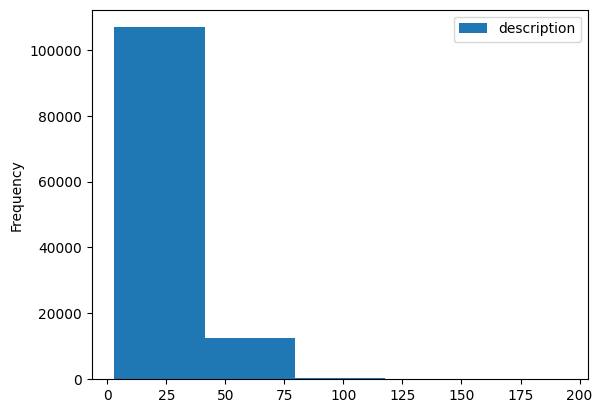

In [13]:
# Find average length of each sentences
pd.DataFrame(sentences_length).plot.hist(bins=5)

In [15]:
#Average length of sentences is 47
max_length = int(np.percentile(sentences_length, 95))
max_length

47

In [16]:
#Setting up word tokenisation
#used to convert words into a one hot vector indices of the word
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, output_mode="int", output_sequence_length= max_length)

text_vectorizer.adapt(train_data.description)

In [17]:
example_text = train_data.description[0]
text_vectorizer([example_text])

<tf.Tensor: shape=(1, 47), dtype=int64, numpy=
array([[1688,   11,   21, 4258, 5887,  683,   16,  743, 4759,    9,  675,
        1698,  952,  244, 8003,  230,  221,    7,  311, 6080,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int64)>

In [18]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 47,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [19]:
vocab_list = text_vectorizer.get_vocabulary()
print(f"5 commom words: {vocab_list[:5]}")
print(f"5 Least common words: {vocab_list[-5:]}")
print(f"Length of vocab size: {len(vocab_list)}")

5 commom words: ['', '[UNK]', 'the', 'a', 'to']
5 Least common words: ['004', '0013', '000th', '000strong', '000660se']
Length of vocab size: 93145


In [20]:
# Creating an embedding for tokenised words
embed = tf.keras.layers.Embedding(input_dim=len(vocab_list), 
        output_dim=256, 
        mask_zero=True, 
        input_length=max_length,
        name="Embeddings"
        )

In [33]:
# efficient dataset
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse=False)

train_y = one_hot.fit_transform(train_data.label.to_numpy().reshape(-1, 1))
test_y = one_hot.transform(test_data.label.to_numpy().reshape(-1, 1))

train_dataset_X = tf.data.Dataset.from_tensor_slices(train_data.description.to_numpy())
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_y)
train_dataset = tf.data.Dataset.zip( (train_dataset_X, train_dataset_y) ).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_X = tf.data.Dataset.from_tensor_slices(test_data.description.to_numpy())
test_dataset_y = tf.data.Dataset.from_tensor_slices(test_y)
test_dataset = tf.data.Dataset.zip( (test_dataset_X, test_dataset_y) ).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [38]:
#Creating of models

inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string, name="input_layer")

word_token = text_vectorizer(inputs)
embeddings = embed(word_token)

x = tf.keras.layers.LSTM(units=128)(embeddings)
x = tf.keras.layers.Dense(128, activation="relu")(x)

outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="adam", metrics=["accuracy"])

history = model.fit(train_dataset, steps_per_epoch=int( len(train_dataset) * 0.4), epochs=3, validation_data=test_dataset, validation_steps=len(test_dataset))

Epoch 1/3
1500/1500 [==============================] - 35s 21ms/step - loss: 0.1499 - accuracy: 0.9568 - val_loss: 0.3691 - val_accuracy: 0.8976
Epoch 2/3
1500/1500 [==============================] - 30s 20ms/step - loss: 0.1917 - accuracy: 0.9411 - val_loss: 0.3690 - val_accuracy: 0.8922
Epoch 3/3
 748/1500 [=============>................] - ETA: 14s - loss: 0.1822 - accuracy: 0.9433WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 4500 batches). You may need to use the repeat() function when building your dataset.


1500/1500 [==============================] - 16s 10ms/step - loss: 0.1825 - accuracy: 0.9432 - val_loss: 0.3309 - val_accuracy: 0.9020


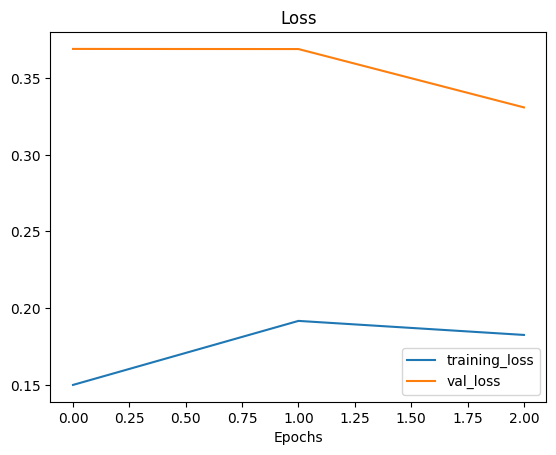

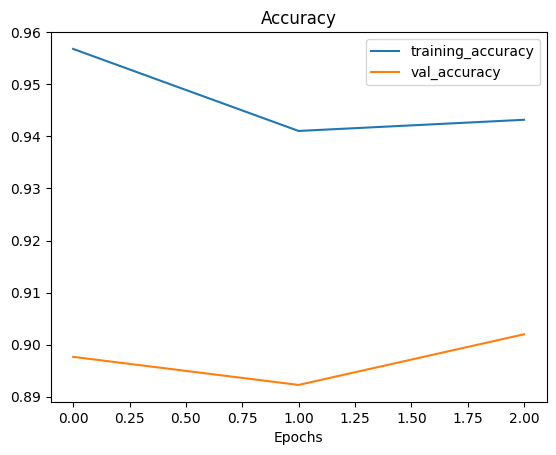

In [39]:
import helper_functions

helper_functions.plot_loss_curves(history)